In [80]:
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm 
import seaborn as sns
sns.set(style='ticks', context='talk')
% matplotlib inline


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.tsa.stattools as tsa

import sys, os, copy
print("Using environment in "+sys.prefix)
print("Python version "+sys.version)

Using environment in /Users/emunsing/Documents/Coding/github/cdips_hpi_forecast/env
Python version 3.5.2 (default, Oct 31 2016, 16:50:28) 
[GCC 4.2.1 Compatible Apple LLVM 7.3.0 (clang-703.0.31)]


In [81]:
fname = 'Metro_Zhvi_AllHomes.csv'

#  Map Zillow RegionID to metro area string
metroRegionID = {'Dallas-Fort Worth, TX':394514,
                     'Atlanta, GA':394347,
                     'Phoenix, AZ':394976,
                     'Las Vegas, NV':394775 }

metroString = {'Dallas':u'Dallas-Fort Worth, TX',
               'Atlanta':u'Atlanta, GA',
               'Phoenix':u'Phoenix, AZ',
               'Vegas':u'Las Vegas, NV'}

df = pd.read_csv('Data/ZHVI/'+fname,index_col=[1])
df = df.drop(['RegionID','SizeRank'],axis=1)
df.columns = pd.DatetimeIndex(df.columns)

In [155]:
cityList = list(metroString.keys())
startDate = None #'2004-01-01'
endDate   = None

i = 6
city = 'Phoenix'
ts = df.loc[metroString[city],startDate:endDate]
y = ts.pct_change(periods=i).shift(-i).dropna()*100

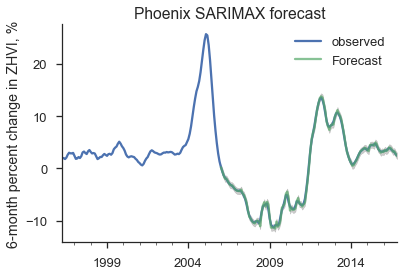

In [157]:
## Basic SARIMAX

model=smt.SARIMAX(y, trend='c', order=(1, 1, 1))
res=model.fit()
pred = res.get_prediction(start='2006-01-01')
pred_ci = pred.conf_int()
ax = y.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7)
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
plt.title('%s SARIMAX forecast'%city)
plt.ylabel("6-month percent change in ZHVI, %")
plt.legend()
sns.despine()


In [96]:
def getRMSE(x,y):
    # X: Pandas TimeSeries of actual data
    # Y: Either a Pandas TimeSeries of prediction data, OR a Pandas DataFrame with each column as different series 
    diff = x - y
    
    if type(y)== pd.core.series.Series:
        return np.sqrt(diff.pow(2).sum()/diff.count())
    else:
        return np.sqrt(diff.pow(2).sum(axis=0) / diff.count(axis=0))

In [103]:
## Compare results for all cities

cityList = list(metroString.keys())
cityList.sort()
startDate = None #'2004-01-01'
endDate   = None

monthsForwards = 6

for city in cityList:
    ts = df.loc[metroString[city],startDate:endDate]
    y = ts.pct_change(periods=monthsForwards).shift(-monthsForwards).dropna()*100

    model=smt.SARIMAX(y, trend='c', order=(1, 1, 1))
    res=model.fit()
    pred = res.get_prediction(start='2006-01-01')
    print("Prediction error for %s: %.4f %%"%(city,getRMSE(y,pred.predicted_mean)))


Prediction error for Atlanta: 0.2585 %
Prediction error for Dallas: 0.3280 %
Prediction error for Phoenix: 0.3114 %
Prediction error for Vegas: 0.3492 %


In [148]:
# Validation: Walk-forwards, increasing our training set by one month at a time.
#  This helps me rest assured that the model is actually predicting out-of-sample.

results = pd.DataFrame()

trainUntil    = '2005-12'
trainEndIndex = y.index.get_loc(trainUntil).stop
trainingEnds  = y.index[trainEndIndex-1]
testingStarts = y.index[trainEndIndex]
testDateList  = y.loc[testingStarts:,].index

for testDate in testDateList:

    trainSet = y.loc[:trainingEnds]
    model=smt.SARIMAX(trainSet, trend='c', order=(1, 1, 1))
    res=model.fit()
    myForecast = res.forecast()
    results.loc[testDate,city] = myForecast[testDate]
    
    trainingEnds = testDate